# Modelo Random Forest para Clasificación de Emociones a través de Audio


In [131]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import librosa
import csv
import scipy
import matplotlib.pyplot as plt
import os
from IPython.display import Audio
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing 
import librosa.display
from sklearn.model_selection import train_test_split, cross_validate

In [111]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [112]:
%cd /content/drive/MyDrive/ML Proyecto

/content/drive/MyDrive/ML Proyecto


## Análisis y procesamiento de Audio

In [113]:
DATASET = 'Dataset/Emotions/'

In [114]:
paths=[]
labels=[]

for dirname, _, filenames in os.walk(DATASET):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename[::-1].split('.')[0][::-1]
        name = dirname[::].split('/')[2]
        name_complete = name+'.'+label
        labels.append(name_complete.lower())

In [115]:
data = pd.DataFrame({'speech':paths,'label':labels})
data.sample(10) # Retorna una muestra de items aleatoria

,speech,label
2763,Dataset/Emotions/Disgusted/OAF_back_disgust.wav,disgusted.wav
2898,Dataset/Emotions/Disgusted/OAF_pain_disgust.wav,disgusted.wav
5765,Dataset/Emotions/Fearful/1035_ITS_FEA_XX.wav,fearful.wav
7540,Dataset/Emotions/Happy/1019_TIE_HAP_XX.wav,happy.wav
927,Dataset/Emotions/Angry/n22.wav,angry.wav
2304,Dataset/Emotions/Disgusted/1059_IEO_DIS_LO.wav,disgusted.wav
3901,Dataset/Emotions/Disgusted/1042_MTI_DIS_XX.wav,disgusted.wav
7632,Dataset/Emotions/Happy/1022_ITH_HAP_XX.wav,happy.wav
4362,Dataset/Emotions/Fearful/1070_IWW_FEA_XX.wav,fearful.wav
4867,Dataset/Emotions/Fearful/OAF_neat_fear.wav,fearful.wav


In [116]:
# Convierte las clase no numericas a numericas. 
label_encoder = preprocessing.LabelEncoder()
data['label'] = data['label'].apply(lambda x: str(x).split('.wav')[0])
data['label']= label_encoder.fit_transform(data['label'])

In [117]:
# Contenido de labels: Clases del dataset
data['label'].unique()

array([0, 1, 2, 3, 4, 5, 6])

In [118]:
data.tail()

,speech,label
12793,Dataset/Emotions/Suprised/YAF_white_ps.wav,6
12794,Dataset/Emotions/Suprised/YAF_puff_ps.wav,6
12795,Dataset/Emotions/Suprised/YAF_mob_ps.wav,6
12796,Dataset/Emotions/Suprised/YAF_raid_ps.wav,6
12797,Dataset/Emotions/Suprised/YAF_pad_ps.wav,6


In [119]:
# Gráficas de todas las clases
def waveplot(data,sr,emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion,size=20)
    librosa.display.waveshow(data,sr=sr)
    plt.show()
    
def spectogram(data,sr,emotion):
    x=librosa.stft(data)
    xdb=librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    librosa.display.specshow(xdb,sr=sr,x_axis='time',y_axis='hz')
    plt.colorbar()
    plt.title("Espectograma")

def mfcc(data,sr,emotion):
    x=librosa.feature.mfcc(data)   
    xdb=librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    librosa.display.specshow(xdb,sr=sr,x_axis='time')
    plt.colorbar()
    plt.title("MFCC Coeficientes")

def ana_emotion(emotion:str, df:pd.DataFrame):
    path=np.array(df['speech'][df['label']==emotion])[0]
    data,sampling_rate=librosa.load(path)
    waveplot(data,sampling_rate,emotion)
    spectogram(data,sampling_rate,emotion)
    mfcc(data,sampling_rate,emotion)
    #Audio(path)


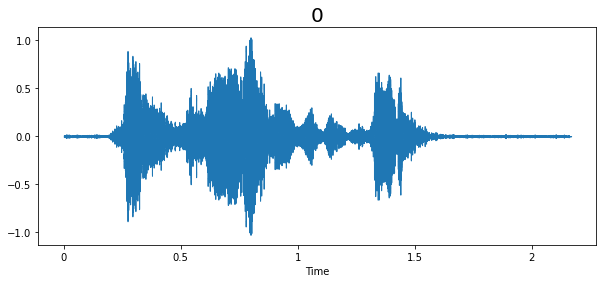

Emocion:  0


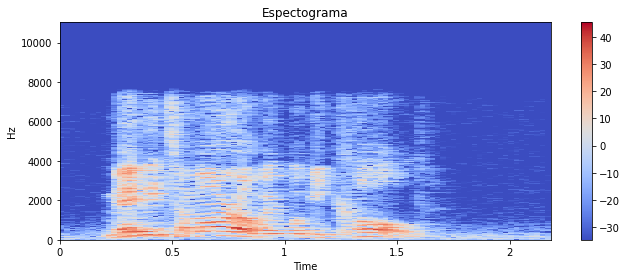

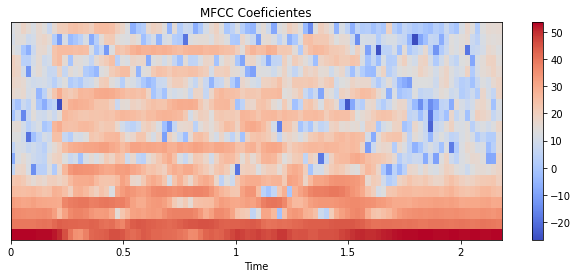

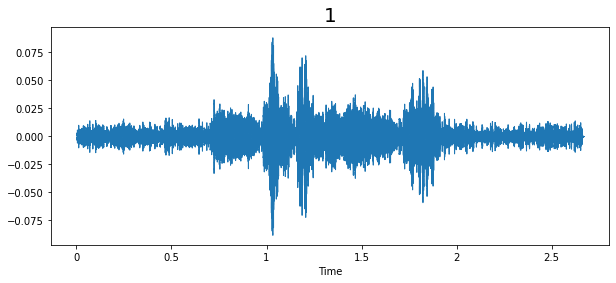

Emocion:  1


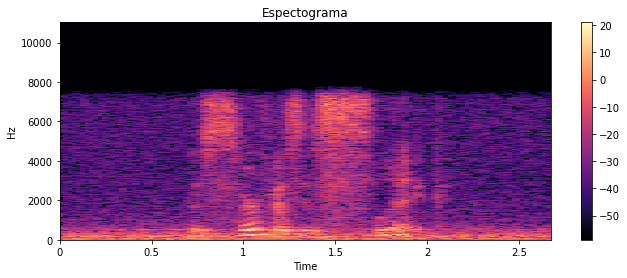

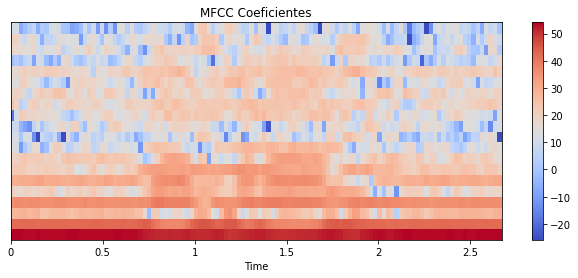

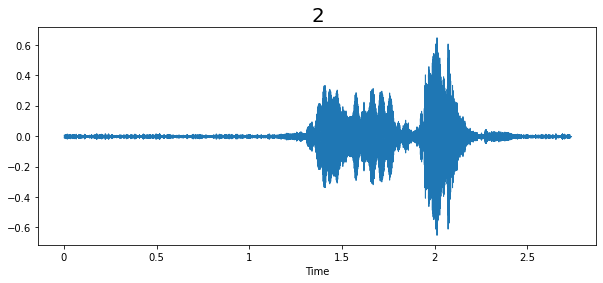

Emocion:  2


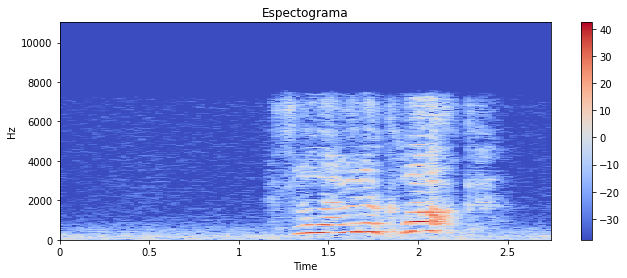

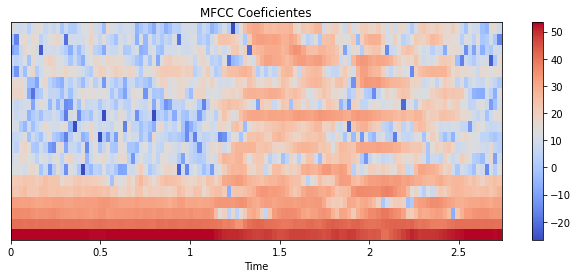

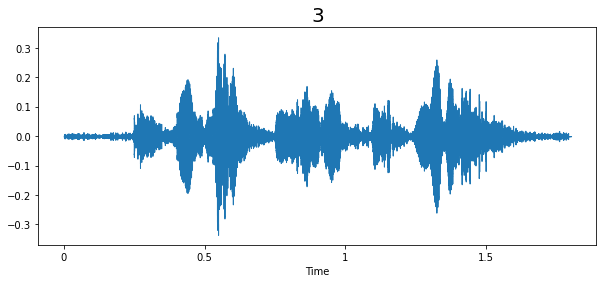

Emocion:  3


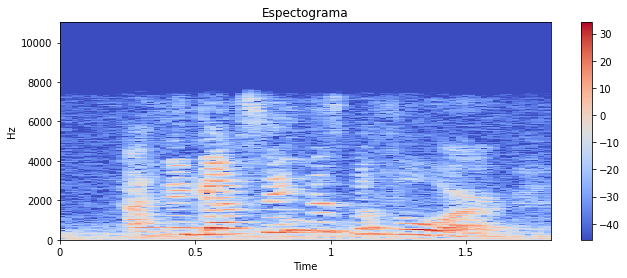

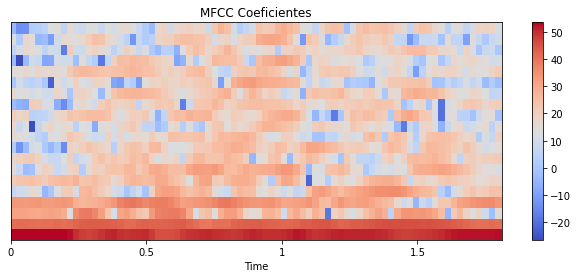

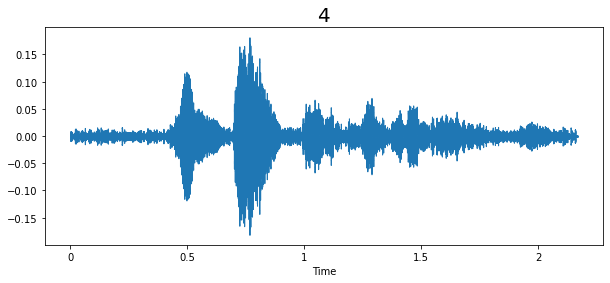

Emocion:  4


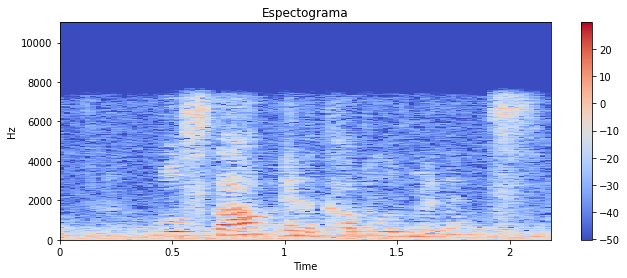

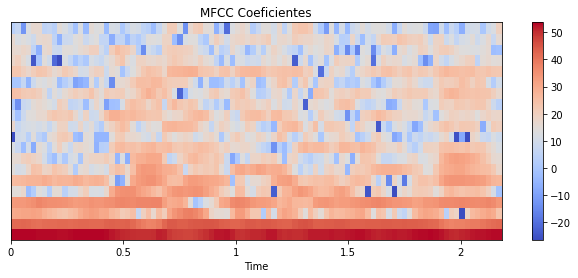

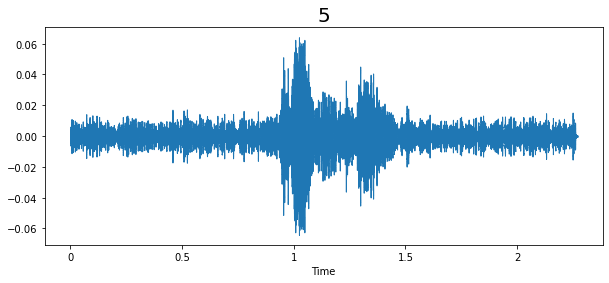

Emocion:  5


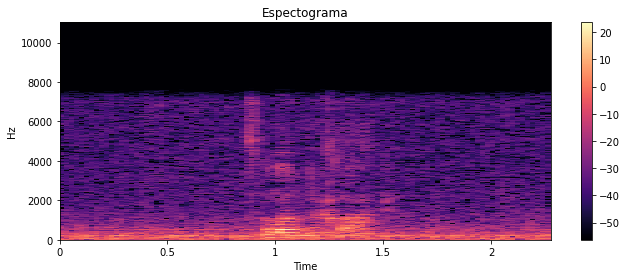

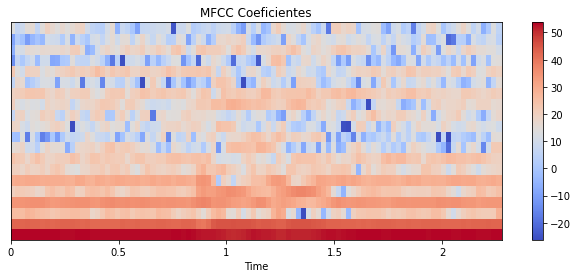

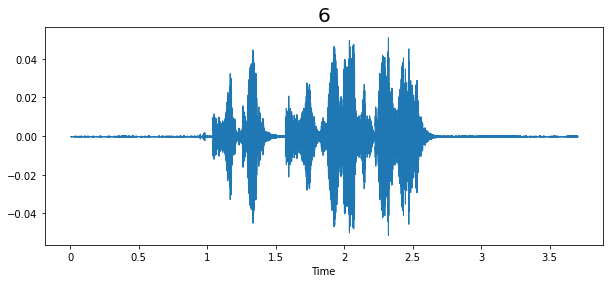

Emocion:  6


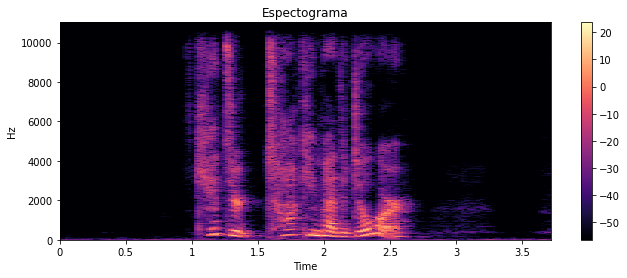

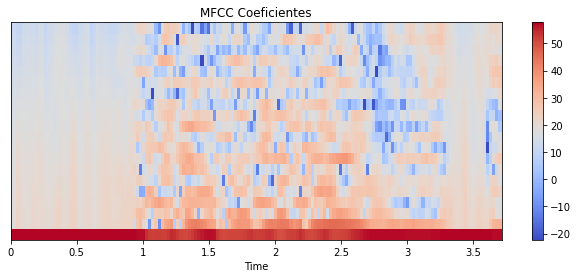

In [120]:
for i in data['label'].unique().tolist(): # ver uno de cada sentimiento
    ana_emotion(i,data)
    print("Emocion: ",i)


In [122]:
#Coeficientes Ceptrales, genera los vectores caracteristicos de la señal de audio, se utilizan en reconocimiento del habla.
def MFCC(filename):
    y, sr = librosa.load(filename,duration=3,offset=0.5)
    return np.mean(librosa.feature.mfcc(y=y,sr=sr,n_mfcc=128).T,axis=0)

mfcc= data['speech'].apply(lambda x:MFCC(x))

In [123]:
mfcc

0        [-272.2177, 131.70934, 1.304399, 40.96423, -24...
1        [-304.77814, 142.68356, 1.011827, 43.578926, -...
2        [-246.64069, 125.15544, -23.190067, 21.447384,...
3        [-303.75735, 114.176636, -12.304601, 55.247948...
4        [-332.6372, 142.58604, -8.861435, 50.068325, -...
                               ...                        
12793    [-376.6187, 70.30242, -6.669177, 3.369576, -26...
12794    [-354.5567, 64.49377, -18.220366, -10.872995, ...
12795    [-356.81293, 101.117805, -18.964403, -8.430914...
12796    [-352.4507, 80.6331, -12.117418, 14.775229, -1...
12797    [-313.99927, 65.370094, -38.370342, 4.8188043,...
Name: speech, Length: 12798, dtype: object

In [125]:
np.save('Dataset/mfccmean.npy', mfcc)

In [126]:
import numpy as np
X = np.asarray(mfcc.to_list())
y = np.asarray(data['label'])

In [127]:
X

array([[-2.72217712e+02,  1.31709335e+02,  1.30439901e+00, ...,
         7.31225824e-03,  2.49762535e-01,  6.06464863e-01],
       [-3.04778137e+02,  1.42683563e+02,  1.01182699e+00, ...,
        -3.92397970e-01,  3.84660438e-02, -4.88117011e-03],
       [-2.46640686e+02,  1.25155441e+02, -2.31900673e+01, ...,
         6.29639149e-01,  6.02834284e-01, -4.47779894e-02],
       ...,
       [-3.56812927e+02,  1.01117805e+02, -1.89644032e+01, ...,
         2.62751095e-02,  2.22327173e-01, -3.85862827e-01],
       [-3.52450714e+02,  8.06331024e+01, -1.21174183e+01, ...,
        -5.25073111e-02, -1.58527344e-01,  9.97003019e-02],
       [-3.13999268e+02,  6.53700943e+01, -3.83703423e+01, ...,
        -5.78601778e-01,  7.27764517e-02, -3.36562753e-01]], dtype=float32)

In [128]:
y

array([0, 0, 0, ..., 6, 6, 6])

In [ ]:
# #Estandarizar todo
# sc = StandardScaler()
# X = sc.fit_transform(X)

In [129]:
print(f'Dimensiones mfcc:{X.shape}')
print(f'Dimensiones label:{y.shape}')

Dimensiones mfcc:(12798, 128)
Dimensiones label:(12798,)


In [132]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [133]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Random Forest 
pipeline = Pipeline(steps = [
    ('standarize', StandardScaler()),
    ('RandomForest', RandomForestClassifier())
])

## GridSearch con RandomForest

In [134]:
parameters = {
    'RandomForest__n_estimators': [50, 100, 150, 200],
    'RandomForest__max_depth': [None, 5, 10, 15], 
    'RandomForest__criterion': ['gini','entropy']
}

In [135]:
grid = GridSearchCV(estimator=pipeline,
                    param_grid=parameters,
                    scoring=['precision_micro','recall_micro','accuracy'],
                    refit= 'accuracy',
                    verbose=4,
                    n_jobs= -1,
                    cv=3)

In [136]:
RandomForestClassifier().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [138]:
grid.fit(X_train, y_train)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('standarize', StandardScaler()),
                                       ('RandomForest',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'RandomForest__criterion': ['gini', 'entropy'],
                         'RandomForest__max_depth': [None, 5, 10, 15],
                         'RandomForest__n_estimators': [50, 100, 150, 200]},
             refit='accuracy',
             scoring=['precision_micro', 'recall_micro', 'accuracy'],
             verbose=4)

In [139]:
print(f'Los mejores parámetros del modelo son: {grid.best_params_}')

Los mejores parámetros del modelo son: {'RandomForest__criterion': 'gini', 'RandomForest__max_depth': None, 'RandomForest__n_estimators': 200}


In [140]:
ytest_predic=grid.predict(X_test)
ytrain_predic=grid.predict(X_train)

In [145]:
from sklearn.metrics import recall_score, precision_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report, SCORERS
def display_metrics(y_true, y_pred):
    '''
    y_true: El vector de la variable dependiente(target)
    y_pred: El vector con las predicciónes hechas por el dataset

    Calcula las diferentes métricas para evaluar el desempeño del modelo
    '''

    recall = recall_score(y_true, y_pred, average='macro')
    pres = precision_score(y_true, y_pred, average='macro')
    accur = accuracy_score(y_true, y_pred)
    f1_scr = f1_score(y_true, y_pred, average='macro')
    conf_mtx = confusion_matrix(y_true, y_pred)
    all_metric = classification_report(y_true, y_pred)

    print(f'Recall: {recall}')
    print(f'Precision: {pres}')
    print(f'Accuracy: {accur}')
    print(f'f1_score: {f1_scr}')
    print('\n')
    print('All metrics:')
    print(all_metric)
    print('\n')
    disp = ConfusionMatrixDisplay(conf_mtx)
    #plt.figure(figsize=(10,8))
    disp.plot()
    # sns.heatmap(disp, annot=True, fmt="d");


Recall: 0.9997485073541438
Precision: 0.9997801436786996
Accuracy: 0.999739538114256
f1_score: 0.9997642603107683


All metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1946
           1       1.00      1.00      1.00      1675
           2       1.00      1.00      1.00      1831
           3       1.00      1.00      1.00      1945
           4       1.00      1.00      1.00      1620
           5       1.00      1.00      1.00      1954
           6       1.00      1.00      1.00       547

    accuracy                           1.00     11518
   macro avg       1.00      1.00      1.00     11518
weighted avg       1.00      1.00      1.00     11518





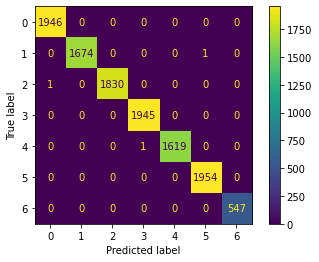

In [146]:
display_metrics(y_train, ytrain_predic)

Recall: 0.6266230973312007
Precision: 0.6199888174278831
Accuracy: 0.5953125
f1_score: 0.61364815608676


All metrics:
              precision    recall  f1-score   support

           0       0.61      0.80      0.69       221
           1       0.57      0.48      0.52       188
           2       0.62      0.34      0.44       216
           3       0.55      0.50      0.53       222
           4       0.55      0.60      0.57       175
           5       0.61      0.77      0.68       213
           6       0.83      0.89      0.86        45

    accuracy                           0.60      1280
   macro avg       0.62      0.63      0.61      1280
weighted avg       0.59      0.60      0.58      1280





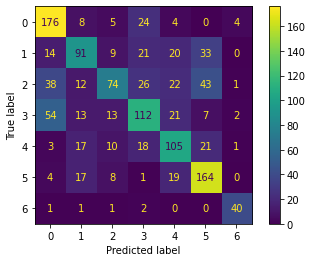

In [147]:
display_metrics(y_test, ytest_predic)